# Imports 

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


# Model definition

In [111]:
torchvision.models.resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [112]:
class ResBlock(nn.Module):
    """
    Basic Residual block class, each block contains 2 convolutions, batchnorms and ReLU 
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
        skip = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += skip
        out = nn.ReLU()(out)
        return out


In [113]:
class ResLayer(nn.Module):
    def __init__(self, resblock, in_channels, out_channels, n_blocks, stride=1):
        super(ResLayer, self).__init__()
        strides = [stride] + [1] * (n_blocks - 1)
        self.blocks = nn.Sequential()

        for index, stride in enumerate(strides):
            self.blocks.add_module(f"block{index}", resblock(in_channels, out_channels, stride))
            in_channels = out_channels 
    def forward(self, x):
        return self.blocks(x)

In [114]:
class ResNet(nn.Module):
    def __init__(self, resblock, n_blocks=None, n_classes=10, architecture="18"):
        super(ResNet, self).__init__()
        architecture_presets = {
            "10": [1, 1, 1, 1],
            "18": [2, 2, 2, 2],
            "34": [3, 4, 6, 3]
        }

        if n_blocks is None:
            n_blocks = architecture_presets.get(architecture, [2, 2, 2, 2]) #resnet18 is a default

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResLayer(resblock, 64, 64, n_blocks[0], stride=1)
        self.layer2 = ResLayer(resblock, 64, 128, n_blocks[1], stride=2)
        self.layer3 = ResLayer(resblock, 128, 256, n_blocks[2], stride=2)
        self.layer4 = ResLayer(resblock, 256, 512, n_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Model training and testing

In [115]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


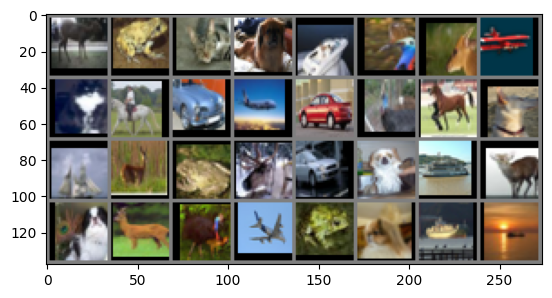

deer  frog  cat   dog   ship  bird  deer  plane cat   horse car   plane car   bird  horse dog   ship  deer  frog  deer  car   dog   ship  deer  dog   deer  bird  plane frog  dog   ship  ship 


In [116]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [117]:
def train(model, trainloader, device, n_epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss {running_loss / 100:.3f}')
                running_loss = 0.0

def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network on the test images: {accuracy} %')
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


In [118]:
device = torch.device('cuda:0')
resnet10 = ResNet(ResBlock, architecture="10")
resnet10.apply(initialize_weights)
resnet18 = ResNet(ResBlock, architecture="18")
resnet18.apply(initialize_weights)
resnet34 = ResNet(ResBlock, architecture="34")
resnet34.apply(initialize_weights)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResLayer(
    (blocks): Sequential(
      (block0): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (block1): ResBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [119]:
print("Resnet10 results:")
train(resnet10, trainloader, device, lr=0.001, n_epochs=8)

Resnet10 results:
Epoch 1, Batch 100: Loss 1.990
Epoch 1, Batch 200: Loss 1.762
Epoch 1, Batch 300: Loss 1.689
Epoch 1, Batch 400: Loss 1.623
Epoch 1, Batch 500: Loss 1.601
Epoch 1, Batch 600: Loss 1.556
Epoch 1, Batch 700: Loss 1.562
Epoch 1, Batch 800: Loss 1.477
Epoch 1, Batch 900: Loss 1.465
Epoch 1, Batch 1000: Loss 1.394
Epoch 1, Batch 1100: Loss 1.374
Epoch 1, Batch 1200: Loss 1.405
Epoch 1, Batch 1300: Loss 1.371
Epoch 1, Batch 1400: Loss 1.329
Epoch 1, Batch 1500: Loss 1.314
Epoch 2, Batch 100: Loss 1.277
Epoch 2, Batch 200: Loss 1.256
Epoch 2, Batch 300: Loss 1.251
Epoch 2, Batch 400: Loss 1.225
Epoch 2, Batch 500: Loss 1.231
Epoch 2, Batch 600: Loss 1.192
Epoch 2, Batch 700: Loss 1.197
Epoch 2, Batch 800: Loss 1.157
Epoch 2, Batch 900: Loss 1.158
Epoch 2, Batch 1000: Loss 1.203
Epoch 2, Batch 1100: Loss 1.151
Epoch 2, Batch 1200: Loss 1.156
Epoch 2, Batch 1300: Loss 1.140
Epoch 2, Batch 1400: Loss 1.142
Epoch 2, Batch 1500: Loss 1.092
Epoch 3, Batch 100: Loss 1.044
Epoch 3, 

In [120]:
print("Resnet18 results:")
train(resnet18, trainloader, device, lr=0.001, n_epochs=10)

Resnet18 results:
Epoch 1, Batch 100: Loss 2.123
Epoch 1, Batch 200: Loss 1.880
Epoch 1, Batch 300: Loss 1.746
Epoch 1, Batch 400: Loss 1.696
Epoch 1, Batch 500: Loss 1.700
Epoch 1, Batch 600: Loss 1.601
Epoch 1, Batch 700: Loss 1.632
Epoch 1, Batch 800: Loss 1.569
Epoch 1, Batch 900: Loss 1.560
Epoch 1, Batch 1000: Loss 1.538
Epoch 1, Batch 1100: Loss 1.487
Epoch 1, Batch 1200: Loss 1.455
Epoch 1, Batch 1300: Loss 1.415
Epoch 1, Batch 1400: Loss 1.405
Epoch 1, Batch 1500: Loss 1.368
Epoch 2, Batch 100: Loss 1.356
Epoch 2, Batch 200: Loss 1.342
Epoch 2, Batch 300: Loss 1.326
Epoch 2, Batch 400: Loss 1.271
Epoch 2, Batch 500: Loss 1.270
Epoch 2, Batch 600: Loss 1.270
Epoch 2, Batch 700: Loss 1.252
Epoch 2, Batch 800: Loss 1.236
Epoch 2, Batch 900: Loss 1.226
Epoch 2, Batch 1000: Loss 1.210
Epoch 2, Batch 1100: Loss 1.200
Epoch 2, Batch 1200: Loss 1.168
Epoch 2, Batch 1300: Loss 1.157
Epoch 2, Batch 1400: Loss 1.184
Epoch 2, Batch 1500: Loss 1.139
Epoch 3, Batch 100: Loss 1.078
Epoch 3, 

In [121]:
print("Resnet34 results:")
train(resnet34, trainloader, device, lr=0.0005, n_epochs=15)

Resnet34 results:
Epoch 1, Batch 100: Loss 2.180
Epoch 1, Batch 200: Loss 1.941
Epoch 1, Batch 300: Loss 1.779
Epoch 1, Batch 400: Loss 1.753
Epoch 1, Batch 500: Loss 1.711
Epoch 1, Batch 600: Loss 1.680
Epoch 1, Batch 700: Loss 1.626
Epoch 1, Batch 800: Loss 1.612
Epoch 1, Batch 900: Loss 1.578
Epoch 1, Batch 1000: Loss 1.589
Epoch 1, Batch 1100: Loss 1.528
Epoch 1, Batch 1200: Loss 1.482
Epoch 1, Batch 1300: Loss 1.482
Epoch 1, Batch 1400: Loss 1.441
Epoch 1, Batch 1500: Loss 1.421
Epoch 2, Batch 100: Loss 1.411
Epoch 2, Batch 200: Loss 1.363
Epoch 2, Batch 300: Loss 1.361
Epoch 2, Batch 400: Loss 1.362
Epoch 2, Batch 500: Loss 1.299
Epoch 2, Batch 600: Loss 1.332
Epoch 2, Batch 700: Loss 1.311
Epoch 2, Batch 800: Loss 1.269
Epoch 2, Batch 900: Loss 1.233
Epoch 2, Batch 1000: Loss 1.245
Epoch 2, Batch 1100: Loss 1.224
Epoch 2, Batch 1200: Loss 1.238
Epoch 2, Batch 1300: Loss 1.205
Epoch 2, Batch 1400: Loss 1.190
Epoch 2, Batch 1500: Loss 1.219
Epoch 3, Batch 100: Loss 1.170
Epoch 3, 

In [122]:
test(resnet10, testloader, device)
test(resnet18, testloader, device)
test(resnet34, testloader, device)

Accuracy of the network on the test images: 75 %
Accuracy of the network on the test images: 76 %
Accuracy of the network on the test images: 78 %


Cuda speeds the process drastically, If I used CPU for this it would have taken a minimum of 30 minutes for each of the models